In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import zeros, newaxis
from evaluation.evaluate import evaluate
from evaluation.metrics import * 
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras
from common.data_loader import *
from common.preprocessing import * 
from common.util import set_random_seed
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU,Conv1D ,Dropout,Conv1DTranspose, Bidirectional, TimeDistributed,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from os import path, environ
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
from pytz import timezone


environ["CUDA_VISIBLE_DEVICES"] = "2"
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


2022-07-21 15:42:04.159681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:42:04.280398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:42:04.281792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
SEQ_LEN = 2
BATCH_SIZE = 512
EPOCHS = 100

In [3]:
# Load dataset
full_data = pd.read_csv("data/wtbdata_245days_clean.csv")
# train_data = pd.read_csv("data/train_data.csv")
submission = pd.read_csv("data/sample_submission.csv")
test_raw = pd.read_csv("info/target.csv")
# full_data = full_data.fillna(method = 'bfill')
# train_data = train_data.fillna(method = 'bfill')
# full_data.info()

In [ ]:
data1 = marking_data(data1, None).dropna()

In [ ]:
# full_data = impute_data(full_data)
full_data = outlier_handler(full_data, ['Etmp','Itmp'], smooth = True)



In [4]:
# Preprocessing
full_data = feature_engineering(full_data, compute_Pmax_method ='clipping', compute_Pmax_clipping=False)
# select_features(full_data)

* Data name: Feature engineering
  - Number of data: 4691542
  - Number of nan rows: 720


### best feature score 170

In [ ]:
features = ['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'WspdX', 'Wspd', 'Wspd_cube', 'Pmax', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']
train_data = train_data[features]
data = data[features]

## new feature

In [ ]:
full_data.columns

In [5]:
features = ['TurbID', 'Day', 'Tmstamp',  'Etmp_abs','locX', 'locY','TimeX', 'TimeY', 'DayX', 'DayY', 'WdirX', 'WdirY','Wspd', 'Wspd5', 'Etmp_abs', 'Etmp4', 'Etmp5', 'Patv5','Pab3', 'Pab2', 'Pab1', 'Bspd2', 'Bspd3', 'Bspd1', 'Papt','Patv']
# train_data = train_data[features]
full_data_selectd = full_data[features]

In [6]:
full_data_selectd

,TurbID,Day,Tmstamp,Etmp_abs,locX,locY,TimeX,TimeY,DayX,DayY,WdirX,WdirY,Wspd,Wspd5,Etmp_abs,Etmp4,Etmp5,Patv5,Pab3,Pab2,Pab1,Bspd2,Bspd3,Bspd1,Papt,Patv
0,1,1,0.000000,273.891720,3000.0,6000.0,1.000000,0.000000,0.999852,0.017202,0.927641,0.373474,6.17,NaN,273.891720,NaN,NaN,NaN,1.00,1.00,1.00,7.080570,7.080570,7.080570,494.660063,494.66
1,1,1,0.166667,273.849258,3000.0,6000.0,0.999048,0.043619,0.999852,0.017202,0.927641,0.373474,6.17,NaN,273.849258,NaN,NaN,NaN,1.00,1.00,1.00,7.080570,7.080570,7.080570,494.660063,494.66
2,1,1,0.333333,273.790177,3000.0,6000.0,0.996195,0.087156,0.999852,0.017202,0.947042,0.321109,6.27,NaN,273.790177,NaN,NaN,NaN,1.00,1.00,1.00,7.207590,7.207590,7.207590,509.760056,509.76
3,1,1,0.500000,273.717261,3000.0,6000.0,0.991445,0.130526,0.999852,0.017202,0.938613,0.344971,6.42,NaN,273.717261,NaN,NaN,NaN,1.00,1.00,1.00,7.384766,7.384766,7.384766,542.530062,542.53
4,1,1,0.666667,273.633295,3000.0,6000.0,0.984808,0.173648,0.999852,0.017202,0.928486,0.371368,6.25,NaN,273.633295,NaN,NaN,NaN,1.00,1.00,1.00,7.188935,7.188935,7.188935,509.360052,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4691537,134,245,23.166667,242.868429,0.0,6500.0,0.976296,-0.216440,-0.477413,-0.878679,-0.773730,-0.633516,7.79,2.90,242.868429,-1.697299,4.252082,116.38,6.03,6.03,6.03,7.505865,7.505865,7.505865,611.722756,601.44
4691538,134,245,23.333333,242.931520,0.0,6500.0,0.984808,-0.173648,-0.477413,-0.878679,-0.755853,-0.654741,8.06,2.96,242.931520,-1.746719,4.357388,112.60,5.81,5.81,5.81,7.812283,7.812283,7.812283,677.697494,673.79
4691539,134,245,23.500000,243.015600,0.0,6500.0,0.991445,-0.130526,-0.477413,-0.878679,-0.779447,-0.626468,8.08,2.72,243.015600,-1.792335,4.386568,106.34,0.68,0.68,0.68,9.393060,9.393060,9.393060,1006.384668,999.36
4691540,134,245,23.666667,243.122908,0.0,6500.0,0.996195,-0.087156,-0.477413,-0.878679,-0.795368,-0.606127,8.46,2.31,243.122908,-1.851540,4.343315,70.10,0.02,0.02,0.02,10.074109,10.074109,10.074109,1102.423116,1100.89


In [7]:
data = full_data[(full_data['Day']>=6)&(full_data['Day']<=200)]
# data = marking_data(data, None).dropna()
data_selectd = data[features]

In [8]:
data_selectd

,TurbID,Day,Tmstamp,Etmp_abs,locX,locY,TimeX,TimeY,DayX,DayY,WdirX,WdirY,Wspd,Wspd5,Etmp_abs,Etmp4,Etmp5,Patv5,Pab3,Pab2,Pab1,Bspd2,Bspd3,Bspd1,Papt,Patv
720,1,6,0.000000,263.855319,3000.0,6000.0,1.000000,0.000000,0.994678,0.103033,-0.958770,-0.284183,6.12,6.17,263.855319,27.974227,30.741720,494.66,1.00,1.00,1.00,7.039327,7.039327,7.039327,545.130062,545.13
721,1,6,0.166667,263.822741,3000.0,6000.0,0.999048,0.043619,0.994678,0.103033,-0.960050,-0.279829,6.98,6.17,263.822741,27.737777,30.699258,494.66,1.00,1.00,1.00,8.029022,8.029022,8.029022,736.930042,736.93
722,1,6,0.333333,263.790317,3000.0,6000.0,0.996195,0.087156,0.994678,0.103033,-0.945916,-0.324413,8.99,6.27,263.790317,27.497885,30.640177,509.76,1.00,1.00,1.00,10.324140,10.324140,10.324140,1159.050027,1159.05
723,1,6,0.500000,263.757366,3000.0,6000.0,0.991445,0.130526,0.994678,0.103033,-0.929455,-0.368936,8.50,6.42,263.757366,27.255371,30.567261,542.53,1.00,1.00,1.00,9.776642,9.776642,9.776642,1046.770043,1046.77
724,1,6,0.666667,263.723209,3000.0,6000.0,0.984808,0.173648,0.994678,0.103033,-0.902886,-0.429881,7.82,6.25,263.723209,27.011056,30.483295,509.36,1.00,1.00,1.00,8.991491,8.991491,8.991491,909.390034,909.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4685057,134,200,23.166667,252.044215,0.0,6500.0,0.976296,-0.216440,-0.955642,-0.294529,-0.999868,0.016231,4.86,7.15,252.044215,13.805161,15.197277,652.66,0.01,0.01,0.01,5.770566,5.770566,5.770566,327.042687,308.65
4685058,134,200,23.333333,251.947605,0.0,6500.0,0.984808,-0.173648,-0.955642,-0.294529,-0.997263,0.073934,4.46,7.01,251.947605,13.679003,15.226212,720.72,0.01,0.01,0.01,5.300394,5.300394,5.300394,240.572254,221.60
4685059,134,200,23.500000,251.856375,0.0,6500.0,0.991445,-0.130526,-0.955642,-0.294529,-0.990913,0.134505,4.23,7.27,251.856375,13.557583,15.254018,713.41,0.01,0.01,0.01,5.039326,5.039326,5.039326,247.042102,220.60
4685060,134,200,23.666667,251.761158,0.0,6500.0,0.996195,-0.087156,-0.955642,-0.294529,-0.971259,0.238025,4.36,7.30,251.761158,13.447279,15.261543,707.18,0.01,0.01,0.01,5.164601,5.164601,5.164601,247.028873,222.15


In [14]:
day = 144
hour = 6
ten_minute = 1
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data_selectd, 
                                                                  in_seq_len=SEQ_LEN*144, 
                                                                  out_seq_len=SEQ_LEN*144, 
                                                                  stride=day, 
                                                                  shuffle=False, 
                                                                  test_size=0.01)


100%|██████████| 134/134 [00:20<00:00,  6.51it/s]


* Data Split
  - Train data(X, y)     : (25167, 288, 23) (25167, 288, 23)
  - Validation data(X, y): (268, 288, 23) (268, 288, 23)
  - Test data(X)         : (134, 288, 23)


In [15]:
test_y = full_data_selectd[(full_data_selectd['Day']>=201)&(full_data_selectd['Day']<=202)]
test_raw = test_raw[(test_raw['Day']>=201)&(test_raw['Day']<=202)]
test_y = test_y.iloc[:,3:].to_numpy().reshape(test_x.shape[0],test_x.shape[1],test_x.shape[2])
test_y.shape

(134, 288, 23)

In [16]:
train_x, train_y = np.array(train_x, dtype=np.float32), np.array(train_y, dtype=np.float32)
val_x, val_y = np.array(val_x, dtype=np.float32), np.array(val_y, dtype=np.float32)
test_x,test_y = np.array(test_x, dtype=np.float32), np.array(test_y, dtype=np.float32)

In [17]:
scaler = MinMaxScaler()
scaler.fit(train_x.reshape(-1,train_x.shape[2]))
train_x = scaler.transform(train_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
train_y= scaler.transform(train_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
val_x = scaler.transform(val_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
val_y = scaler.transform(val_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_x = scaler.transform(test_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_y = scaler.transform(test_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
print("Train data(X, y):", train_x.shape, train_y.shape)
print("Validation data(X, y):", val_x.shape, val_y.shape)
print("Test data(X,y):", test_x.shape, test_y.shape)

Train data(X, y): (25167, 288, 23) (25167, 288, 23)
Validation data(X, y): (268, 288, 23) (268, 288, 23)
Test data(X,y): (134, 288, 23) (134, 288, 23)


In [13]:
train_y = train_y[:,:,-1].reshape(-1,train_x.shape[1],1)
val_y = val_y[:,:,-1].reshape(-1,train_x.shape[1],1)
test_y = test_y[:,:,-1].reshape(-1,train_x.shape[1],1)

In [18]:
# Generate dataset
train_ds = generate_dataset(train_x, train_y, batch_size=BATCH_SIZE)
test_ds = generate_dataset(val_x, val_y, batch_size=BATCH_SIZE)

2022-07-21 15:55:31.890441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 15:55:31.896930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:55:31.899121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:55:31.900392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [41]:
set_random_seed(32)
model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(train_x[0].shape[0],train_x[0].shape[1]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(GRU(units=512,dropout=0.3, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(train_y[0].shape[0], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=512,dropout=0.3, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
# model.add(Dense(128, name = 'Dense-layer')) # Repeat Vector
model.add(TimeDistributed(Dense(units=train_y[0].shape[1], activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

In [42]:
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 1024)             1649664   
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 1024)        0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 1024)        4724736   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 23)          23575     
 ed)                                                             
                                                                 
Total params: 6,397,975
Trainable params: 6,397,975
Non-t

In [43]:
##### Step 4 - Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, # default='rmsprop', an algorithm to be used in backpropagation
              loss='huber', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )
checkpoint_filepath = 'saved_models/checkpoint/ weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True)

In [44]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(test_x)
        y_pred = y_pred.reshape(-1, y_pred.shape[2])
#         y_pred = np.pad(y_pred, ((0,0),(test_x.shape[2]-test_y.shape[2],0)))
        y_pred = scaler.inverse_transform(y_pred)
        y_pred[:,-1] = np.clip(y_pred[:,-1], -0.3, 1550)
        submission['Patv'] =y_pred[:,-1]
        now = datetime.now(timezone('Asia/Seoul'))
        current_time = now.strftime('%Y-%m-%d %H:%M:%S')
        score = evaluate(submission)
        submission.to_csv(f"output/transformer_prediction_{current_time}_score{round(score)}.csv", index=False)
        print('\n --- Overall Score --- \n\t{}'.format(score))




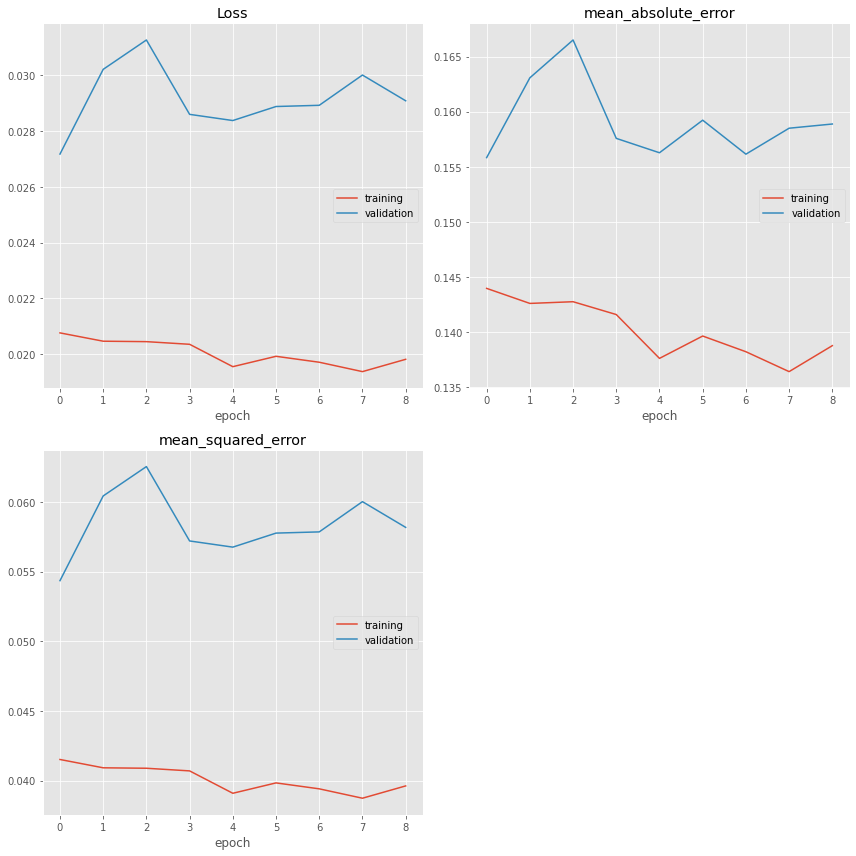

Loss
	training         	 (min:    0.019, max:    0.021, cur:    0.020)
	validation       	 (min:    0.027, max:    0.031, cur:    0.029)
mean_absolute_error
	training         	 (min:    0.136, max:    0.144, cur:    0.139)
	validation       	 (min:    0.156, max:    0.167, cur:    0.159)
mean_squared_error
	training         	 (min:    0.039, max:    0.042, cur:    0.040)
	validation       	 (min:    0.054, max:    0.063, cur:    0.058)
5/5 [==============================] - 0s 40ms/step
Accuracy:  43.8015%

 	 RMSE: 485.77529707064156, MAE: 363.8425727182336

 --- Overall Score --- 
	424.8089348944376
50/50 [==============================] - 34s 678ms/step - loss: 0.0198 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1388 - val_loss: 0.0291 - val_mean_squared_error: 0.0582 - val_mean_absolute_error: 0.1589
Epoch 10/1000
19/50 [==========>...................] - ETA: 20s - loss: 0.0199 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1378

In [ ]:
##### Step 5 - Fit the model on the dataset
history = model.fit(train_ds, # input data, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=1000, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=[ PlotLossesKeras(),
                               model_checkpoint_callback,
                               EarlyStopping(patience=50, restore_best_weights=True),
                              CustomCallback()
                              ], # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    #validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    validation_data=test_ds, # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                   )

print('-------------------- Evaluation on Test Data --------------------')

# y_pred = model.predict(test_x)
# y_pred = y_pred.reshape(-1, y_pred.shape[2])
# # y_pred_descaled = scaler.inverse_transform(y_pred)
# # y_pred_descaled[:,-2] = np.clip(y_pred_descaled[:,-2], -0.3, 1550)
# # y_pred_descaled[:,-1] = np.clip(y_pred_descaled[:,-1], -0.3, 1550)

# submission['Patv'] =y_pred[:,-1]
# now = datetime.now()
# current_time = now.strftime('%Y-%m-%d %H:%M:%S')
# score = evaluate(submission)
# submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)
# print('\n --- Overall Score --- \n\t{}'.format(score))

now = datetime.now(timezone('Asia/Seoul'))
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
model.save(f'saved_models/_model_ep{EPOCHS}_b{BATCH_SIZE}_seq{SEQ_LEN}_{current_time}')

1) Training set

In [ ]:
# for not scaled
y_true = train_y
y_pred = model.predict(train_x)
y_true = y_true.reshape(-1, y_true.shape[2])
y_pred = y_pred.reshape(-1, y_pred.shape[2])
y_pred[:,-2] = np.clip(y_pred[:,-2], -0.3, 1550)
y_pred[:,-1] = np.clip(y_pred[:,-1], -0.3, 1550)

In [55]:
# for scaled
y_true = train_y
y_pred = model.predict(train_x)
y_true = y_true.reshape(-1, y_true.shape[2])
y_pred = y_pred.reshape(-1, y_pred.shape[2])
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)
y_pred[:,-2] = np.clip(y_pred[:,-2], -0.3, 1550)
y_pred[:,-1] = np.clip(y_pred[:,-1], -0.3, 1550)

787/787 [==============================] - 35s 44ms/step


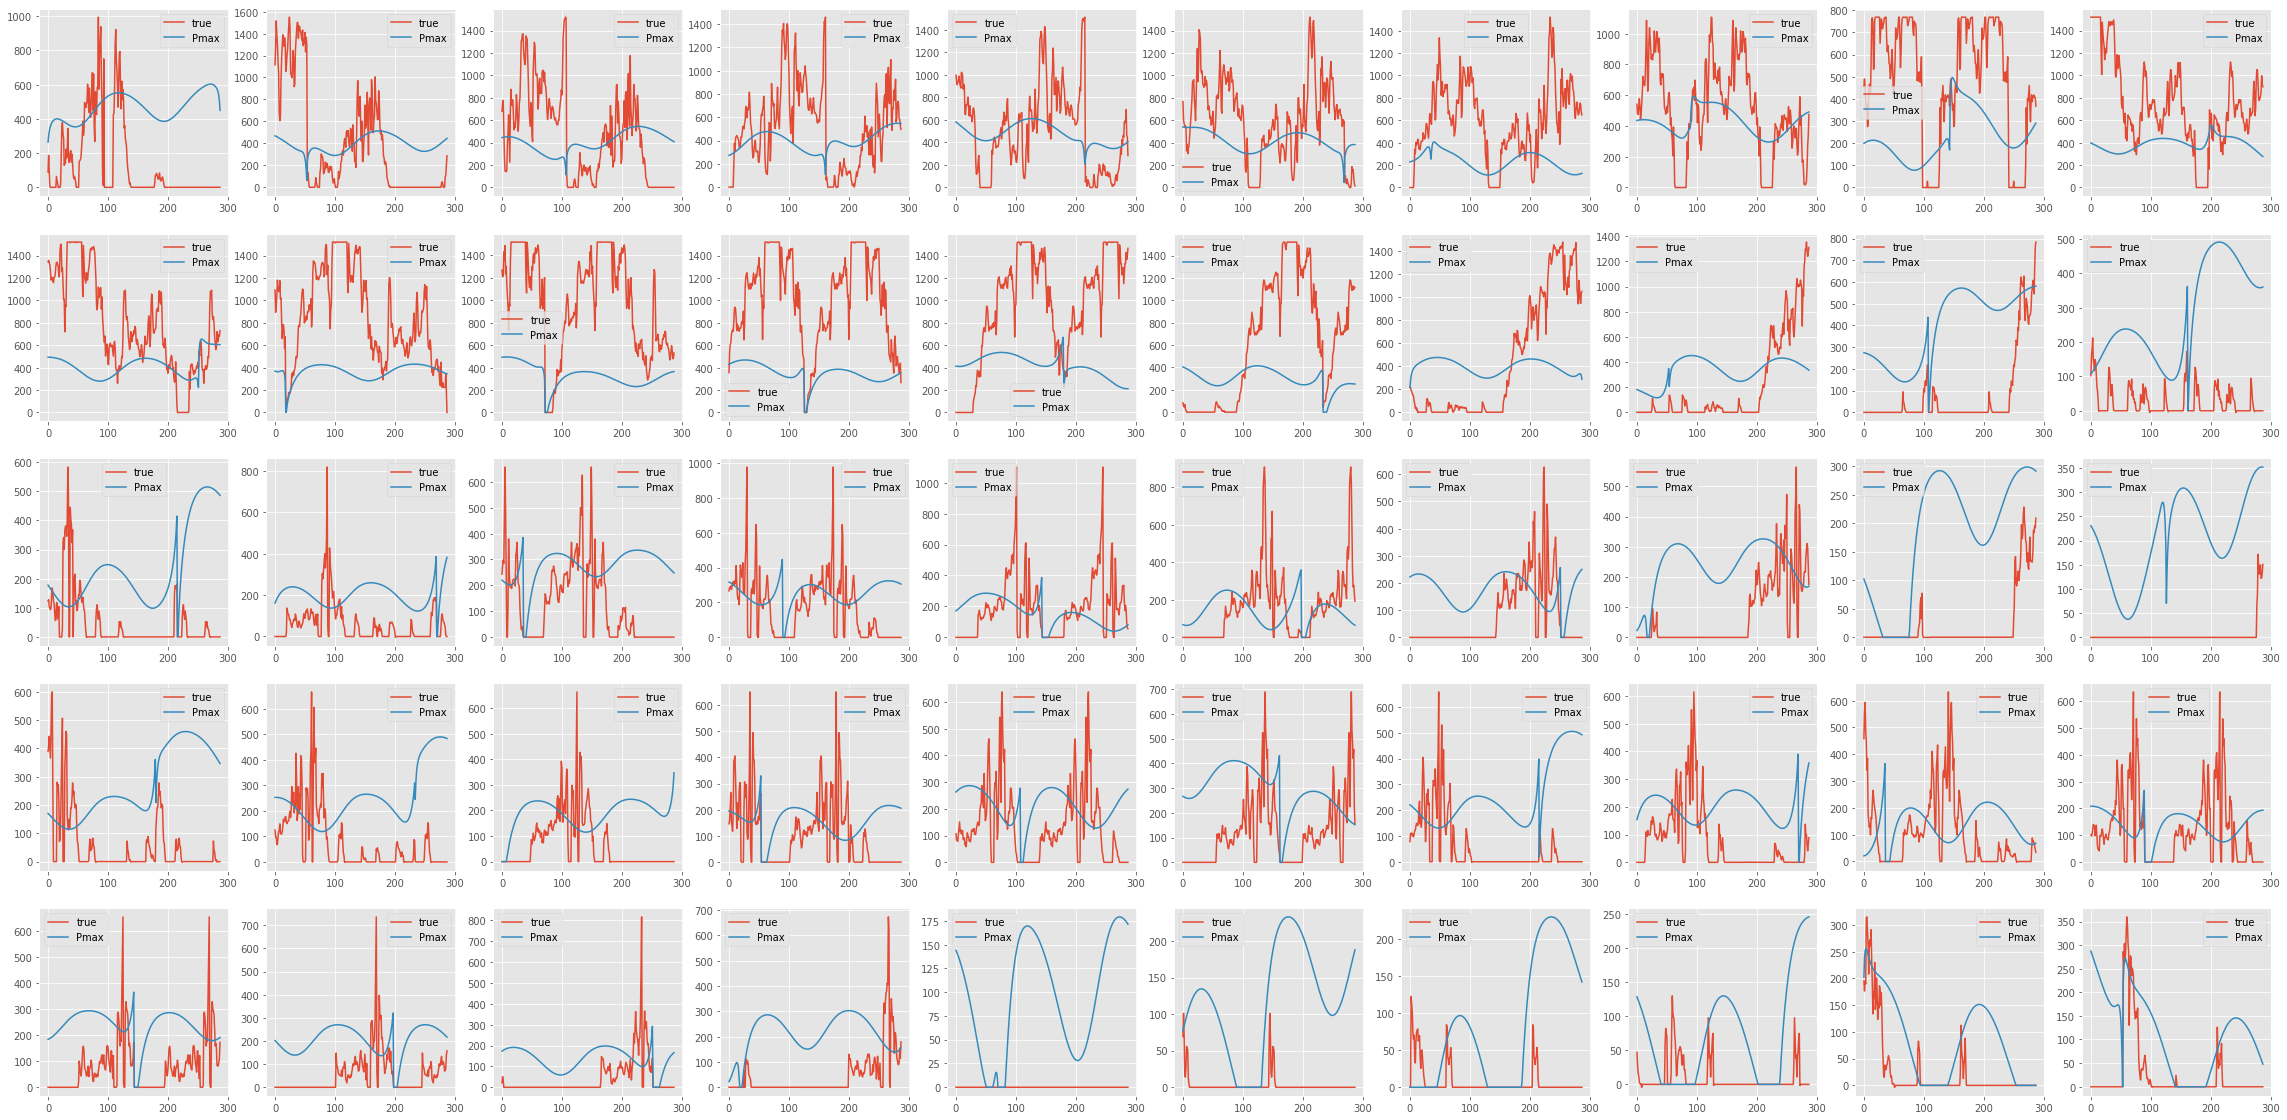

In [56]:

len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)][:,-1][:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)][:,-1][:144*2]
#     y_p2 = y_pred[len_turb*i:len_turb*(i+1)][:,-1][:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='Pmax')
#     ax.plot(y_p2, label='Patv')
    ax.legend()

2) Validation set

In [ ]:
y_true = val_y_scaled
y_pred = model.predict(val_x_scaled)

In [ ]:
y_true = y_true.reshape(-1, y_true.shape[2])
y_pred = y_pred.reshape(-1, y_pred.shape[2])
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)
y_pred[:,-2] = np.clip(y_pred[:,-2], -0.3, 1550)

In [ ]:

len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true_descaled[len_turb*i:len_turb*(i+1)][:,-1][:144*2]
    y_p = y_pred_descaled[len_turb*i:len_turb*(i+1)][:,-2][:144*2]
    y_p2 = y_pred_descaled[len_turb*i:len_turb*(i+1)][:,-1][:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='Pmax')
    ax.plot(y_p2, label='Patv')
    ax.legend()

3) Test set

In [ ]:
# for not scaled if test_y
y_true = test_y
y_pred = model.predict(test_x)
y_true = y_true.reshape(-1, y_true.shape[2])
y_pred = y_pred.reshape(-1, y_pred.shape[2])
y_pred[:,-2] = np.clip(y_pred[:,-2], -0.3, 1550)
y_pred[:,-1] = np.clip(y_pred[:,-1], -0.3, 1550)

In [60]:
# for scaled if 
y_true = test_y
y_pred = model.predict(test_x)
y_true = y_true.reshape(-1, y_true.shape[2])
y_pred = y_pred.reshape(-1, y_pred.shape[2])
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)
y_pred[:,-2] = np.clip(y_pred[:,-2], -0.3, 1550)
y_pred[:,-1] = np.clip(y_pred[:,-1], -0.3, 1550)

5/5 [==============================] - 0s 44ms/step


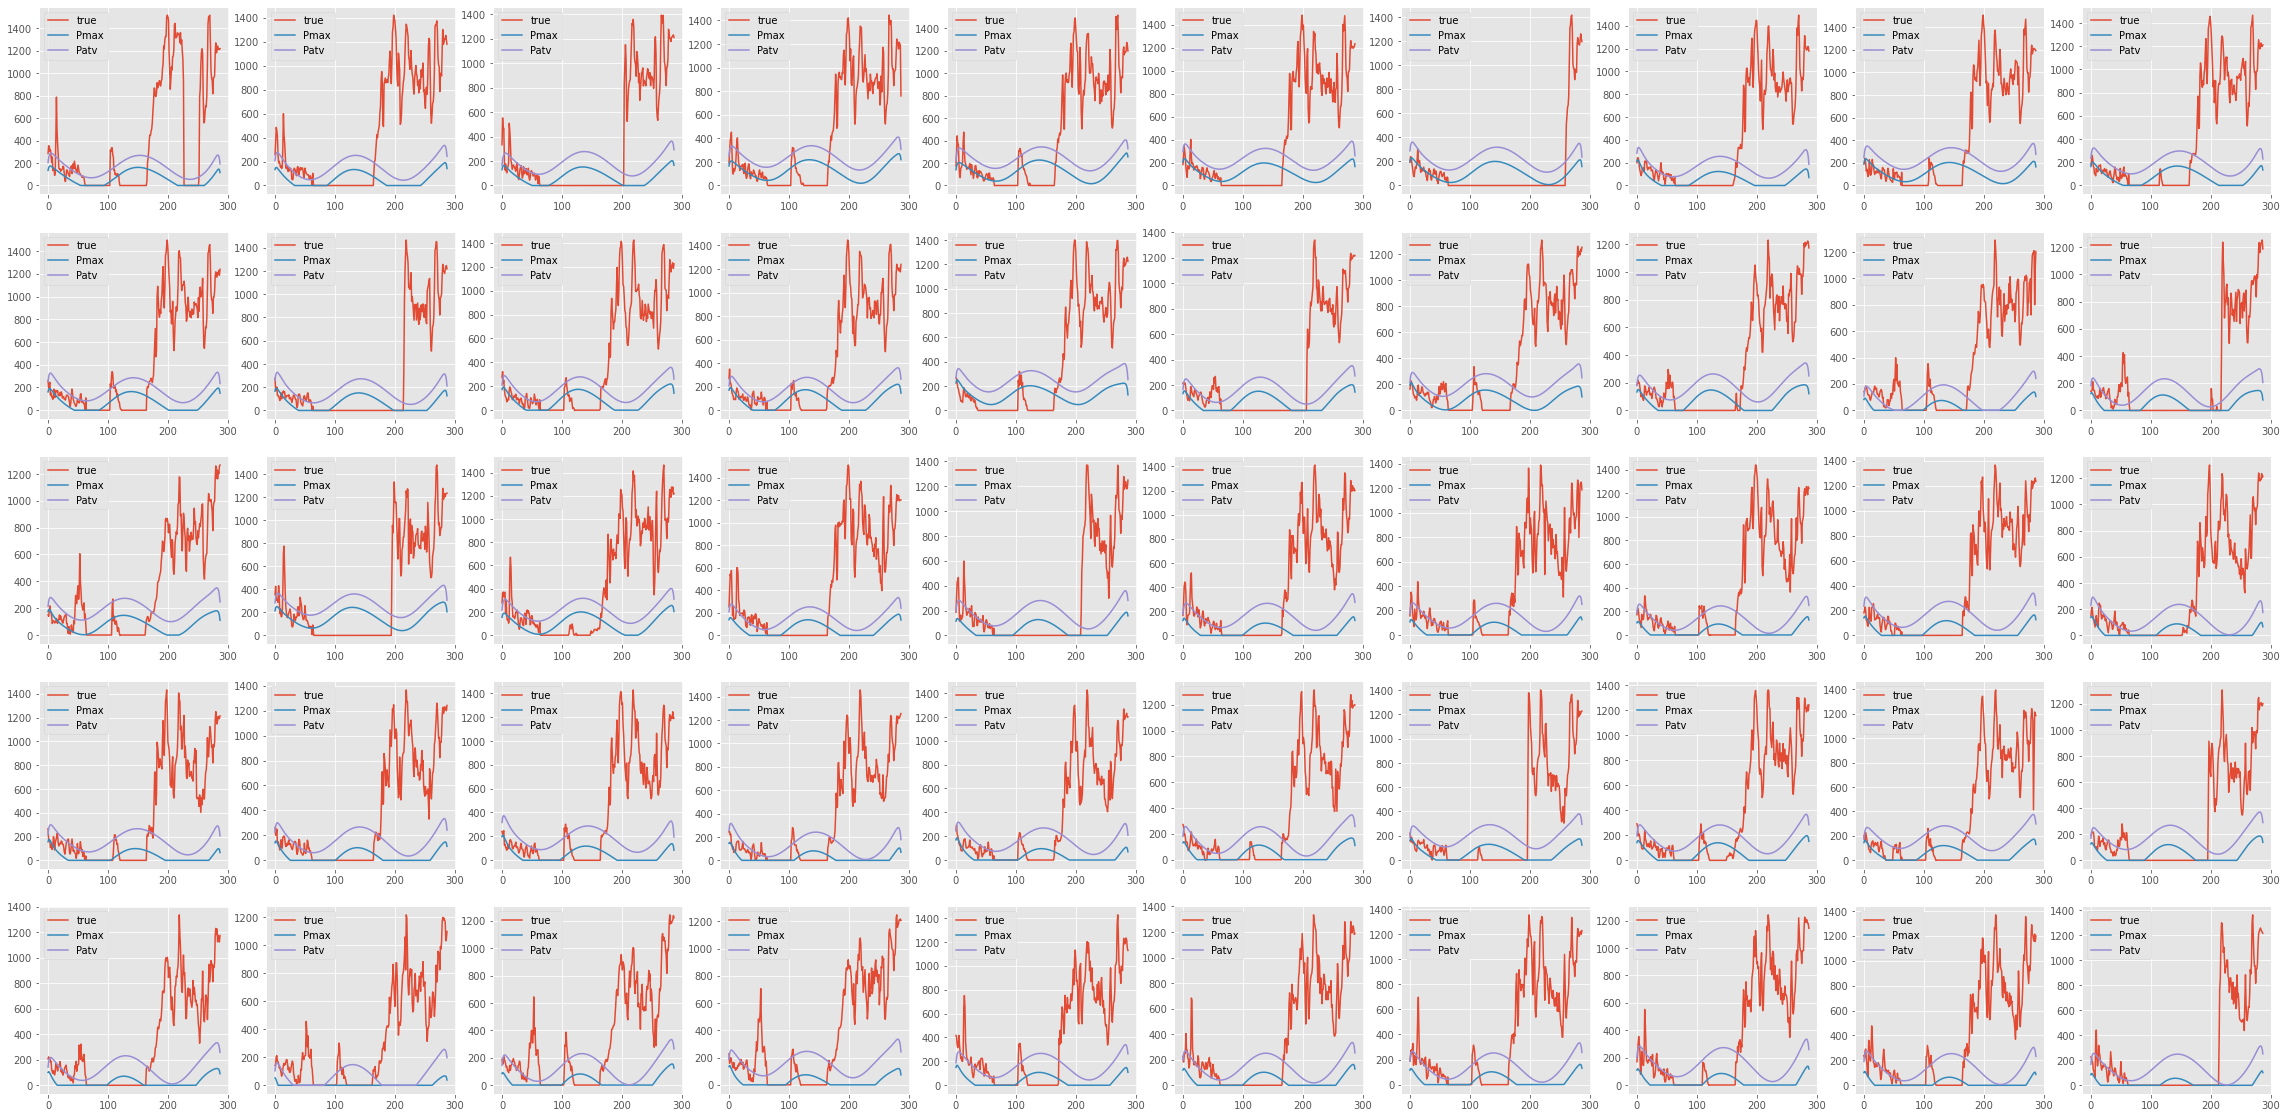

In [61]:

len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)][:,-1][:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)][:,-2][:144*2]
    y_p2 = y_pred[len_turb*i:len_turb*(i+1)][:,-1][:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='Pmax')
    ax.plot(y_p2, label='Patv')
    ax.legend()

# Result

In [ ]:
y_pred = model.predict(test_x_scaled)
y_pred = y_pred.reshape(-1, y_pred.shape[2])
y_pred_descaled = scaler.inverse_transform(y_pred)
y_pred_descaled[:,-2] = np.clip(y_pred_descaled[:,-2], -0.3, 1550)
y_pred_descaled[:,-1] = np.clip(y_pred_descaled[:,-1], -0.3, 1550)

In [ ]:
y_pred_descaled[:,-1]

In [ ]:
from evaluation.evaluate import *
from evaluation.metrics import *

In [ ]:
score  = 0
submission['Patv'] =y_pred_descaled[:,-2]
submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)

In [ ]:
evaluate(submission)

In [ ]:
print('-------------------- Accuracy and Score --------------------')

submission['Patv'] =y_pred_descaled[:,-2]
submission['Prtv'] =y_pred_descaled[:,-2]
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
score = evaluate(submission)
submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)
print('\n --- Overall Score --- \n\t{}'.format(score))
